### Import libraries

In [1]:
import os
from collections import deque
import random
import numpy as np
import tensorflow as tf
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import datetime
import pandas as pd
from sklearn import preprocessing
from tensorflow import keras


SEQ_LEN = 10
FUTURE_PERIOD_PREDICT = 2
RATIO_TO_PREDICT = "BTC-USD"
EPOCHS = 10
BATCH_SIZE = 64
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"

### Preprocessing data func

In [2]:
def classify(current, future):
    if float(future) > float(current):
        return 1  # buy
    else:
        return 0  # short

    
def preprocess_df(df):
    df = df.drop('future', 1)
    
    for col in df.columns:
        if col != "target":
            df[col] = df[col].pct_change() #percentage change https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pct_change.html
            df.dropna(inplace=True)
            df[col] = preprocessing.scale(df[col].values)
        
    df.dropna(inplace=True)
    
    sequential_data = []
    prev_days = deque(maxlen=SEQ_LEN) #https://docs.python.org/2/library/collections.html
    
    for i in df.values:
        prev_days.append([n for n in i[:-1]]) #so we are not taking target
        
        if len(prev_days) == SEQ_LEN:
            sequential_data.append([np.array(prev_days), i[-1]])

    random.shuffle(sequential_data) # if more than 1 dimension use numpy.random.shuffle
    
    buys = []
    sells = []
    
    for seq, target in sequential_data:
        if target == 0:
            sells.append([seq, target])
        elif target == 1:
            buys.append([seq, target])
            
    random.shuffle(buys)
    random.shuffle(sells)
    
    lower = min(len(buys), len(sells))
    
    #
    buys = buys[:lower]
    sells = sells[:lower]
    
    sequential_data = buys+sells
    
    random.shuffle(sequential_data)
    
    X = []
    y = []
    
    for seq, target in sequential_data:
        X.append(seq)
        y.append(target)
        
    return np.array(X).astype("float32"),  np.array(y)
    
    

In [3]:
def preprocess_df_no_shuffle(df):
    df = df.drop('future', 1)
    
    for col in df.columns:
        if col != "target":
            df[col] = df[col].pct_change() #percent chnage https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pct_change.html
            df.dropna(inplace=True)
            df[col] = preprocessing.scale(df[col].values)
        
    df.dropna(inplace=True)
    
    sequential_data = []
    prev_days = deque(maxlen=SEQ_LEN) #https://docs.python.org/2/library/collections.html
    
    for i in df.values:
        prev_days.append([n for n in i[:-1]]) #so we are not taking target
        
        if len(prev_days) == SEQ_LEN:
            sequential_data.append([np.array(prev_days), i[-1]])

    X = []
    y = []
    
    for seq, target in sequential_data:
        X.append(seq)
        y.append(target)
        
    return np.array(X).astype("float32"),  np.array(y)
    

### Loading data

In [4]:
main_df = pd.DataFrame()

ratios = ["BTC-USD", "LTC-USD","ETH-USD","BCH-USD"]


for ratio in ratios:
    dataset = "crypto_data/"+ratio+".csv"
    df = pd.read_csv(dataset, names=["time","low","high","open","close","volume"])
    
    df.rename(columns={"close": f"{ratio}_close"}, inplace=True)
    
    df.set_index("time", inplace=True)
    df = df[[f"{ratio}_close"]]
    
    if len(main_df) == 0:
        main_df = df
    else:
        main_df = main_df.join(df)
        

main_df['future'] = main_df[f"{RATIO_TO_PREDICT}_close"].shift(-FUTURE_PERIOD_PREDICT)        
main_df['target'] = list(map(classify, main_df[f"{RATIO_TO_PREDICT}_close"], main_df["future"]))
                                               
print(main_df[[f"{RATIO_TO_PREDICT}_close", "future", "target"]].head(10))                      
        

            BTC-USD_close       future  target
time                                          
1528968660    6489.549805  6479.410156       0
1528968720    6487.379883  6479.410156       0
1528968780    6479.410156  6479.979980       1
1528968840    6479.410156  6480.000000       1
1528968900    6479.979980  6477.220215       0
1528968960    6480.000000  6480.000000       0
1528969020    6477.220215  6479.990234       1
1528969080    6480.000000  6478.660156       0
1528969140    6479.990234  6478.660156       0
1528969200    6478.660156  6479.339844       1


In [5]:
# Get only first 1000 of my data for learning and validation
first_10000_df = main_df[:11250]

In [6]:
first_10000_df.shape

(11250, 6)

In [6]:
# Separate last circa 5% of data for validation 
#times = sorted(first_1000_df.index.values)
#last_5pct = times[-int(0.1*len(times))]    

In [7]:
val_first_10000_df = first_10000_df[10000:11250]
train_first_10000_df = first_10000_df[0:10000]

In [8]:
val_first_10000_df.head(11)

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close,future,target
time,,,,,,
1529574360,6719.000000,97.080002,534.219971,874.760010,6719.000000,0
1529574420,6719.000000,97.050003,533.309998,874.770020,6716.069824,0
1529574480,6719.000000,97.040001,533.349976,873.840027,6701.000000,0
1529574540,6716.069824,97.040001,531.030029,873.030029,6692.479980,0
1529574600,6701.000000,96.690002,530.299988,871.059998,6691.169922,0
1529574660,6692.479980,96.639999,528.429993,868.820007,6705.000000,1
1529574720,6691.169922,96.660004,530.000000,871.570007,6717.490234,1
1529574780,6705.000000,96.860001,530.250000,874.169983,6714.209961,1
1529574840,6717.490234,96.989998,531.270020,875.390015,6722.330078,1


In [9]:
train_first_10000_df.tail(11)

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close,future,target
time,,,,,,
1529573700,6731.410156,97.300003,535.469971,878.02002,6727.160156,0
1529573760,6727.160156,97.309998,535.479980,877.50000,6725.990234,0
1529573820,6727.160156,97.309998,535.469971,877.50000,6725.990234,0
1529573880,6725.990234,97.309998,535.440002,NaN,6725.009766,0
1529573940,6725.990234,97.309998,535.030029,877.97998,6720.000000,0
1529574000,6725.009766,97.160004,534.630005,876.00000,6720.000000,0
1529574060,6720.000000,97.080002,534.260010,876.00000,6719.000000,0
1529574120,6720.000000,97.070000,534.650024,874.76001,6719.009766,0
1529574180,6719.000000,97.120003,534.650024,874.76001,6719.009766,1


In [10]:
print(first_10000_df.shape)
print(val_first_10000_df.shape)

(11250, 6)
(1250, 6)


In [11]:
train_X, train_y = preprocess_df(first_10000_df)

In [12]:
validation_X, validation_y = preprocess_df(val_first_10000_df)

In [13]:
train_X.shape

(8344, 10, 4)

In [14]:
train_X.shape[1:]

(10, 4)

##### (samples, time steps, features)

In [14]:
#print(f"train data: {len(train_X)} validation: {len(validation_X)}")
#print(f"Dont buys: {train_y.count(0)}, buys: {train_y.count(1)}")
#print(f"VALIDATION Dont buys: {validation_y.count(0)}, buys: {validation_y.count(1)}")

### Creating and training model

In [15]:
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128, input_shape=(train_X.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128, input_shape=(train_X.shape[1:])))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation="relu"))
model.add(Dropout(0.1))

model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 128)           68096     
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 128)           512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 128)           512       
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               1

In [16]:
print(model.layers[0].trainable_weights)

[<tf.Variable 'lstm/kernel:0' shape=(4, 512) dtype=float32, numpy=
array([[-0.01760007, -0.06842308,  0.00131724, ...,  0.00813081,
        -0.07364095, -0.05021985],
       [ 0.08658342, -0.06957332, -0.05584246, ..., -0.09125143,
        -0.05808169, -0.00751676],
       [-0.0589821 ,  0.07704417,  0.09029597, ...,  0.04833424,
         0.05486737, -0.03261623],
       [-0.03751216, -0.08038867,  0.06733905, ...,  0.0456882 ,
         0.09473245,  0.09375079]], dtype=float32)>, <tf.Variable 'lstm/recurrent_kernel:0' shape=(128, 512) dtype=float32, numpy=
array([[-0.04098034, -0.08731575, -0.01530986, ...,  0.04728113,
         0.03614371, -0.10060884],
       [-0.0125187 ,  0.03462982,  0.11166276, ...,  0.05817623,
         0.06605027,  0.02274137],
       [-0.05290231, -0.07112253, -0.00230098, ..., -0.00127685,
        -0.00421842, -0.03267657],
       ...,
       [ 0.10287214, -0.01293069, -0.02797202, ..., -0.05070201,
         0.00930871,  0.03684404],
       [ 0.02506638,  0.0

#### Taining on first 10.000 rows (next 1.125 is validation)

In [17]:
opt = tf.keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


tensorboard = TensorBoard(log_dir='logs\\'+ NAME)

filepath = "RNN_Final-{epoch:02d}-{val_accuracy:.3f}"
checkpoint = ModelCheckpoint(filepath="models\\" + filepath + ".model",monitor='val_accuracy' ,verbose=1, save_best_only=True, mode='max') # saves only the best ones


history = model.fit(train_X, train_y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(validation_X, validation_y), callbacks = [tensorboard, checkpoint])


model.save("models\\{}".format(NAME) ,save_format='tf')

Train on 8344 samples, validate on 810 samples
Epoch 1/10
8320/8344 [============================>.] - ETA: 0s - loss: 0.8047 - accuracy: 0.5125
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to models\RNN_Final-01-0.500.model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models\RNN_Final-01-0.500.model\assets
8344/8344 [==============================] - 34s 4ms/sample - loss: 0.8047 - accuracy: 0.5123 - val_loss: 0.7015 - val_accuracy: 0.5000
Epoch 2/10
8256/8344 [============================>.] - ETA: 0s - loss: 0.7217 - accuracy: 0.5291
Epoch 00002: val_accuracy improved from 0.50000 to 0.52716, saving model to models\RNN_Final-02-0.527.model
INFO:tensorflow:Assets written to: models\RNN_Final-02-0.527.model\assets
8344/8344 [==============================] - 30s 4ms/sample - loss: 0.7215 - accuracy: 0.5300 - val_loss: 0.6986 - val_accuracy: 0.5272
Epoch 3/10
8320/8344 [=====================

### Display tensorboard

In [36]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [41]:
 %reload_ext tensorboard

In [42]:
%tensorboard --logdir=name1:logs/10-SEQ-2-PRED-1601918260,name2:logs/10-SEQ-2-PRED-1601918260retrained

Reusing TensorBoard on port 6006 (pid 8644), started 0:44:58 ago. (Use '!kill 8644' to kill it.)

### Evaluation

In [3]:
# loaded_model = keras.models.load_model('models\RNN_Final-08-0.644.model')  55 %
# loaded_model = keras.models.load_model('models\RNN_Final-07-0.590.model')  55,4 %
# loaded_model = keras.models.load_model('models\RNN_Final-04-0.585.model')  54,6 %
loaded_model = keras.models.load_model('models\\10-SEQ-2-PRED-1601980864')

### Model scheme

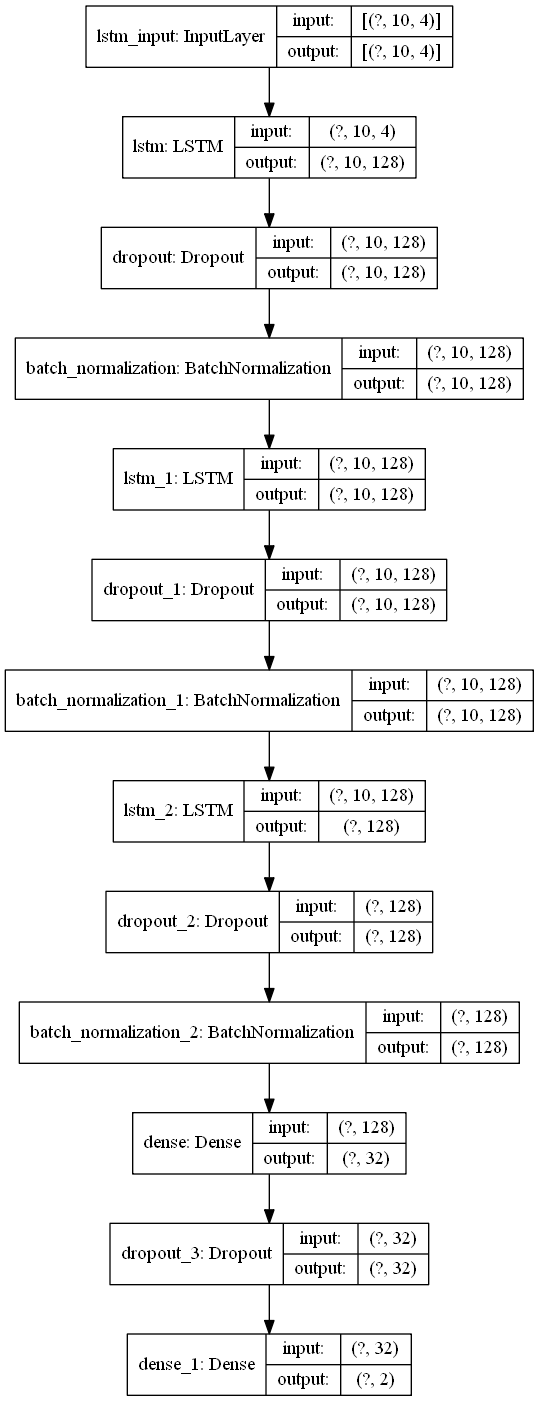

In [4]:
#from tensorflow.keras import plot_model
tf.keras.utils.plot_model(loaded_model, to_file='model.png', show_shapes=True, show_layer_names=True) # visualize model

In [19]:
val_first_10000_df.tail(11)

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close,future,target
time,,,,,,
1529648700,6665.299805,93.620003,515.000000,NaN,6665.299805,0
1529648760,6665.310059,93.639999,515.010010,850.039978,6665.310059,0
1529648820,6665.299805,93.599998,515.010010,850.049988,6660.899902,0
1529648880,6665.310059,93.629997,515.030029,850.039978,6660.899902,0
1529648940,6660.899902,93.529999,514.700012,846.419983,6657.640137,0
1529649000,6660.899902,93.529999,514.700012,846.409973,6655.520020,0
1529649060,6657.640137,93.400002,514.700012,NaN,6655.450195,0
1529649120,6655.520020,93.360001,514.700012,847.200012,6655.439941,0
1529649180,6655.450195,93.360001,514.700012,847.210022,6655.450195,0


In [20]:
main_df[11250:20000]

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close,future,target
time,,,,,,
1529649360,6655.439941,93.400002,515.000000,847.210022,6645.919922,0
1529649420,6658.990234,93.400002,515.090027,846.809998,6652.000000,0
1529649480,6645.919922,93.199997,514.700012,844.869995,6651.990234,1
1529649540,6652.000000,93.239998,514.700012,846.809998,6652.000000,0
1529649600,6651.990234,93.070000,514.260010,846.799988,6652.000000,1
...,...,...,...,...,...,...
1530174240,6121.339844,78.959999,435.399994,703.229980,6121.379883,1
1530174300,6121.370117,78.900002,435.399994,NaN,6121.009766,0
1530174360,6121.379883,78.870003,435.399994,703.229980,6121.009766,0


#### Evaluation on rows 11250-20000

In [21]:
post_validation_X, post_validation_y = preprocess_df(main_df[11250:20000])

In [112]:
loaded_model.evaluate(post_validation_X, post_validation_y)

6994/6994 [==============================] - 3s 382us/sample - loss: 1.8524 - accuracy: 0.5549


[1.8524214009881395, 0.5549042]

### Retraining

###### Train data

In [23]:
another_1000_train_data = main_df[20000:21000]

In [24]:
train_X_second, train_y_second = preprocess_df(another_1000_train_data)

In [25]:
train_X_second.shape

(756, 10, 4)

In [26]:
train_y_second.shape

(756,)

###### Validation data

In [27]:
another_1000_validate_data = main_df[21000:22000]

In [28]:
val_X_second, val_y_second = preprocess_df(another_1000_train_data)

###### Model

In [29]:
NAME_2 = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}-RETRAINED"
opt = tf.keras.optimizers.Adam()

tensorboard = TensorBoard(log_dir='logs\\'+ NAME + 'retrained')

filepath = "RNN_Final-{epoch:02d}-{val_accuracy:.3f}"
checkpoint = ModelCheckpoint(filepath="models\\" + filepath + "retrained.model",monitor='val_accuracy' ,verbose=1, save_best_only=True, mode='max') # saves only the best ones

history = loaded_model.fit(train_X_second, train_y_second, batch_size=128, epochs=6, validation_data=(val_X_second, val_y_second), callbacks = [tensorboard, checkpoint])


loaded_model.save("models\\{}".format(NAME_2) ,save_format='tf')

Train on 756 samples, validate on 756 samples
Epoch 1/6
640/756 [========================>.....] - ETA: 0s - loss: 0.6957 - accuracy: 0.5531
Epoch 00001: val_accuracy improved from -inf to 0.57275, saving model to models\RNN_Final-01-0.573retrained.model
INFO:tensorflow:Assets written to: models\RNN_Final-01-0.573retrained.model\assets
756/756 [==============================] - 8s 11ms/sample - loss: 0.6940 - accuracy: 0.5529 - val_loss: 0.6834 - val_accuracy: 0.5728
Epoch 2/6
640/756 [========================>.....] - ETA: 0s - loss: 0.6877 - accuracy: 0.5609
Epoch 00002: val_accuracy improved from 0.57275 to 0.58069, saving model to models\RNN_Final-02-0.581retrained.model
INFO:tensorflow:Assets written to: models\RNN_Final-02-0.581retrained.model\assets
756/756 [==============================] - 6s 8ms/sample - loss: 0.6905 - accuracy: 0.5595 - val_loss: 0.6794 - val_accuracy: 0.5807
Epoch 3/6
640/756 [========================>.....] - ETA: 0s - loss: 0.6850 - accuracy: 0.5594
Epoch

### Second evaluation on original dataset

In [30]:
second_validate_data = main_df[21000:30000]

In [31]:
second_validation_X, second_validation_y = preprocess_df(second_validate_data)

In [32]:
loaded_model.evaluate(second_validation_X, second_validation_y) #models\\10-SEQ-2-PRED-1601980864

6738/6738 [==============================] - 4s 570us/sample - loss: 0.6895 - accuracy: 0.5448


[0.689537712164681, 0.5448204]

In [33]:
retrained_model = keras.models.load_model('models\\10-SEQ-2-PRED-1601982524-RETRAINED')

In [34]:
retrained_model.evaluate(second_validation_X, second_validation_y)

6738/6738 [==============================] - 3s 419us/sample - loss: 0.6898 - accuracy: 0.5402


[0.6897972778489874, 0.54021966]

## Evaluating and fitting to current data

In [35]:
dataset_path = "crypto_data/2020_10_05_20_17_15.csv"
df_current = pd.read_csv(dataset_path)
df_current.set_index("Datetime", inplace=True)
df_current.head(10)

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
Datetime,,,,
2020-09-29 00:00:00+01:00,10882.307617,46.209499,362.026703,229.652374
2020-09-29 00:01:00+01:00,10854.922852,46.161976,362.060303,229.684937
2020-09-29 00:02:00+01:00,10891.773438,46.162174,362.444305,229.972366
2020-09-29 00:03:00+01:00,10879.347656,46.265980,361.937439,229.668304
2020-09-29 00:04:00+01:00,10881.262695,46.165272,362.052765,229.564697
2020-09-29 00:05:00+01:00,10880.336914,46.177452,362.286926,229.707367
2020-09-29 00:06:00+01:00,10877.445312,46.267822,362.223022,229.719147
2020-09-29 00:07:00+01:00,10879.380859,46.176918,362.219299,229.632339
2020-09-29 00:08:00+01:00,10873.903320,46.261120,362.169342,229.587036


In [36]:
df_current.shape

(9297, 4)

In [37]:
df_current['future'] = df_current[f"{RATIO_TO_PREDICT}_close"].shift(-FUTURE_PERIOD_PREDICT)        
df_current['target'] = list(map(classify, df_current[f"{RATIO_TO_PREDICT}_close"], df_current["future"]))

In [38]:
df_current_first_2000 = df_current[0:2000]

In [39]:
df_current_first_2000.head(10)

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close,future,target
Datetime,,,,,,
2020-09-29 00:00:00+01:00,10882.307617,46.209499,362.026703,229.652374,10891.773438,1
2020-09-29 00:01:00+01:00,10854.922852,46.161976,362.060303,229.684937,10879.347656,1
2020-09-29 00:02:00+01:00,10891.773438,46.162174,362.444305,229.972366,10881.262695,0
2020-09-29 00:03:00+01:00,10879.347656,46.265980,361.937439,229.668304,10880.336914,1
2020-09-29 00:04:00+01:00,10881.262695,46.165272,362.052765,229.564697,10877.445312,0
2020-09-29 00:05:00+01:00,10880.336914,46.177452,362.286926,229.707367,10879.380859,0
2020-09-29 00:06:00+01:00,10877.445312,46.267822,362.223022,229.719147,10873.903320,0
2020-09-29 00:07:00+01:00,10879.380859,46.176918,362.219299,229.632339,10875.782227,0
2020-09-29 00:08:00+01:00,10873.903320,46.261120,362.169342,229.587036,10877.922852,1


In [40]:
current_validation_X, current_validation_y = preprocess_df(df_current_first_2000)

In [41]:
current_validation_X.shape

(1956, 10, 4)

In [42]:
retrained_model.evaluate(current_validation_X, current_validation_y)

1956/1956 [==============================] - 1s 504us/sample - loss: 0.7050 - accuracy: 0.5424


[0.704958102454437, 0.54243356]

### Retraining on current data

In [43]:
df_current_first_rest = df_current[2000:9295]

In [44]:
df_current_first_rest

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close,future,target
Datetime,,,,,,
2020-09-30 10:08:00+01:00,10718.445312,46.062771,355.738617,228.055023,10711.221680,0
2020-09-30 10:09:00+01:00,10716.569336,46.008167,355.705811,228.119812,10712.639648,0
2020-09-30 10:10:00+01:00,10711.221680,46.018993,355.532074,227.940079,10708.922852,0
2020-09-30 10:11:00+01:00,10712.639648,46.013588,355.057831,227.932373,10711.221680,0
2020-09-30 10:12:00+01:00,10708.922852,46.029156,354.893890,228.055420,10708.259766,0
...,...,...,...,...,...,...
2020-10-05 19:07:00+01:00,10695.600586,45.867489,351.596619,220.650558,10696.185547,1
2020-10-05 19:08:00+01:00,10696.081055,45.867508,351.599335,220.649902,10687.146484,0
2020-10-05 19:09:00+01:00,10696.185547,45.867485,351.600494,220.650360,10687.548828,0


In [81]:
current_train_X, current_train_y = preprocess_df_no_shuffle(df_current_first_rest)

In [87]:
current_train_X[0:1+1]

array([[[-1.0158294 ,  0.43201625, -0.86640245,  0.98458314],
        [ 0.63077044, -0.8742646 ,  0.4366001 , -2.2500412 ],
        [-0.80933726, -0.76930404, -0.22897312,  1.6579145 ],
        [-0.29218307,  1.6991833 , -1.2259587 , -2.4035861 ],
        [-0.03015476, -3.616397  ,  0.19577791, -0.1619525 ],
        [ 0.01904811,  1.065771  ,  2.492225  ,  1.3290027 ],
        [-1.4637244 ,  1.0298264 ,  0.08566082, -0.88800794],
        [ 0.48083222, -0.16298698, -0.7839883 ,  0.45599213],
        [ 0.20068443, -0.11337088, -0.3043235 , -1.0502458 ],
        [ 1.0520561 ,  0.01289252,  0.11370678, -0.39575493]],

       [[ 0.63077044, -0.8742646 ,  0.4366001 , -2.2500412 ],
        [-0.80933726, -0.76930404, -0.22897312,  1.6579145 ],
        [-0.29218307,  1.6991833 , -1.2259587 , -2.4035861 ],
        [-0.03015476, -3.616397  ,  0.19577791, -0.1619525 ],
        [ 0.01904811,  1.065771  ,  2.492225  ,  1.3290027 ],
        [-1.4637244 ,  1.0298264 ,  0.08566082, -0.88800794],
      

In [86]:
current_train_y[0+1]

1.0

In [90]:
NAME_CURRENT = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}-RETRAINED_CURRENT_DATA"

for i in range(len(current_train_X)):

    loaded_model.fit(current_train_X[i:i+1], current_train_y[i:i+1], batch_size=1, epochs=1)
    loaded_model.evaluate(current_train_X[i:i+1], current_train_y[i:i+1])
    
    #if m % 1000 == 0: # save model every 1000th iteration
        #loaded_model.save("models\\{}".format(NAME_CURRENT) ,save_format='tf')
    

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.6709 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.6746 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7187 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.7329 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.6697 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.5952 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.6685 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.7334 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7204 - accuracy: 0.0000e+00
Epoch 2/2
1

1/1 [==============================] - 0s 7ms/sample - loss: 1.6945 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.6623 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.8040 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 12ms/sample - loss: 0.6603 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.5320 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.7294 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.2105 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7306 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2984 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [===

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.7340 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7089 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.5001 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.7078 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.3511 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7064 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.5704 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6816 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.7943 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6856 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.5070 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.6855 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.4167 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7014 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.9208 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7015 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.5575 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7013 - accuracy: 0.0000e+00
Epoch 2

1/1 [==============================] - 0s 6ms/sample - loss: 0.0658 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.6933 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.2055 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6929 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.4477 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6941 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.8703 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.6945 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0386 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 

Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.0274 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.6848 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.1834 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.6841 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 4.7240 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.6831 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 3.5790 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6819 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.2771 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/

1/1 [==============================] - 0s 15ms/sample - loss: 0.7140 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 3.0856 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7140 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.9066 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7136 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 4ms/sample - loss: 0.0937 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7128 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2469 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7118 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [=============

1/1 [==============================] - 0s 5ms/sample - loss: 1.5015 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6848 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0118 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.6844 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.2813 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6836 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0193 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.7038 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.0677 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [=======

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1906 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.7121 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 4.6488 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7110 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 2.4964 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7097 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 5.6420 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.6783 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0013 - accuracy: 1.0000
Train on 1 samples
Epoc

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7056 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 2.3169 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6808 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0506 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6806 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.4640 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7064 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 4.0731 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.7066 - accuracy: 0.0000e+00
Epo

1/1 [==============================] - 0s 6ms/sample - loss: 11.3095 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6807 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.3100e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6807 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.3827e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6802 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0070 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6795 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0102 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==========

1/1 [==============================] - 0s 6ms/sample - loss: 0.2897 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7205 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 0.0015 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6665 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.6252 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6663 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.4772 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7213 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 6.8565 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [=======

Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.4253 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6653 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.7478 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7230 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.4715 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7238 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0141 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6632 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 8.2139 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7253 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.5982 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7249 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.6662 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6630 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.4548 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6633 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 4.2780 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6633 - accuracy: 1.0000
Epoch 2

1/1 [==============================] - 0s 6ms/sample - loss: 2.4120 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7288 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 14.2851 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7278 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 11.3891 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6608 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.9073e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7258 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0940 - accuracy: 1.0000
Train on 1 samples
Epoch 1/

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0044 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6697 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0815 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7175 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.5756e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7176 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0033 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7172 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0289 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6852 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 4.3749e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6844 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.7449 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6833 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0316 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6820 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.2727 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6806 - accuracy: 1.0000
Epoch 2/2
1/1 [

1/1 [==============================] - 0s 6ms/sample - loss: 0.0048 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7176 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.3426 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6688 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0022 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6682 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.8437 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6674 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0018 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [===========

Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 5.7190 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7147 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 13.1954 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7135 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 13.2188 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7122 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 11.9880 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6759 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0074 - accuracy: 1.0000
Train on 1 sampl

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6949 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 10.5827 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6920 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0012 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6923 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.8091 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6941 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.5735 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6923 - accuracy: 1.0000
Epoch 

1/1 [==============================] - 0s 6ms/sample - loss: 0.6945 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6915 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.3731 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6919 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.8276 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6944 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.7173 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6942 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.2245 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.2517e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7189 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.3842e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6679 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 2.7192 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6676 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.9782 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6670 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 12.3202 - accuracy: 0.0000e+00
Train on 1 samples
Epo

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6729 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0182 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6723 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0057 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6714 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0176 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.6703 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0249 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6691 - accuracy: 1.0000
Epoch 2/2
1/1 [============

1/1 [==============================] - 0s 7ms/sample - loss: 0.2347 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7260 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.5709 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7246 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.5401 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6642 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0312 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 20ms/sample - loss: 0.6652 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0559 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [=======

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0600 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7016 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0035 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6860 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.5732 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6995 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.3061 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6876 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.5999 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6912 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 13.9226 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.6899 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6885 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6869 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 12.0926 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.6853 - accuracy: 1.0000
Epoch 2

1/1 [==============================] - 0s 9ms/sample - loss: 0.0109 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 25ms/sample - loss: 0.6982 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1391 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6892 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.3812 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 20ms/sample - loss: 0.6964 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.8822 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.6957 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.3614 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [=======

1/1 [==============================] - 0s 9ms/sample - loss: 0.0744 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.7130 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.1917 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7129 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 0.0821 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 20ms/sample - loss: 0.7125 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.1457 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.7117 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0261 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [===

Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 3.9244 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6945 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6928 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6911 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 3.2064 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6894 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 9.6084 - accuracy: 0.0000e+00
Train on 1 samples
Ep

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6804 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 3.2193 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6791 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.3038 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7089 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0020 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.7098 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0069 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6763 - accuracy: 1.0000
Epoch 2/2
1

1/1 [==============================] - 0s 6ms/sample - loss: 1.5921 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6992 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0584 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6984 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0031 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6890 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 3.1425 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6896 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 3.6631 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [===

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.9087e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6781 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 2.3007e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6775 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.5919 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6766 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0154 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6756 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 2.5281e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/

1/1 [==============================] - 0s 15ms/sample - loss: 0.6577 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.3658 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6568 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1241 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6557 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.3460 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6545 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 4ms/sample - loss: 0.2861 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7348 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7409 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 0.0418 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7407 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.7066 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7402 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.4483 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7393 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.5412 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6500 - accuracy: 1.0000
Epo

1/1 [==============================] - 0s 6ms/sample - loss: 14.4706 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 25ms/sample - loss: 0.7293 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 12.4975 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.6594 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6601 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6603 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 2.3842e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.3628 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7169 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.4260 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.6703 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.7189e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.6703 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1677 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6700 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.6928e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/

1/1 [==============================] - 0s 16ms/sample - loss: 0.6591 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 9.6060e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6582 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 4.8375e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6571 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.2186e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7318 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.3574 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7327 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [=====================

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6467 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0399 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6468 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.3279e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6465 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 5.9605e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6459 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7437 - accuracy: 0.0000e+00
Epoch 2/2
1

Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 2.7365 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7238 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0035 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6645 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0327 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7218 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2204 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7210 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.6846 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.7102 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.6775 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 2.0240e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6783 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.1812e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.7080 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 9.3393 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.7076 - accuracy: 0.0000e+0

1/1 [==============================] - 0s 7ms/sample - loss: 0.7655 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6909 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0155 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6899 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1079 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6976 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.6271 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6984 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.8684 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [===

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0082 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6877 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.3224 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6994 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 4.2696 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6998 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2526 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6865 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 4.0755 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6944 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1009 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6939 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.3618 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6931 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.5173 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6921 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 2.1719 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6954 - accuracy: 0.0000e+00
Epo

1/1 [==============================] - 0s 6ms/sample - loss: 10.0483 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.7174 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0075 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7181 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 6.5563e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.6686 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 2.9562 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6683 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.3240 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==

Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 2.2811 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6750 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2037 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6756 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.4973 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7109 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.3155 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7107 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 6.2567 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6939 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.1799 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6921 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.0619 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6959 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.3222 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6972 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.5077 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6978 - accuracy: 0.0000e+00
Epo

1/1 [==============================] - 0s 5ms/sample - loss: 12.7275 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7021 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 8.5576 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7017 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 11.2637 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6853 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.6689e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6857 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0070 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7024 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 7.9577 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7030 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 3.7344 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6833 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0693 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6831 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0333 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6990 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0080 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6979 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0137 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6965 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 2.2516 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6951 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.3176 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6935 - accuracy: 0.0000e+00

1/1 [==============================] - 0s 7ms/sample - loss: 0.1668 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6888 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0521 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6978 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.7091 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6978 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2307 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6975 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0776 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [=======

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.5863 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.7110 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 12.7860 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6752 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 9.0599e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6747 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.7684e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6739 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epo

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6989 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.7935 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6976 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1147 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6962 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0783 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6917 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.0153 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6927 - accuracy: 1.0000
Epoch 2

1/1 [==============================] - 0s 5ms/sample - loss: 0.6012 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6908 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.7689 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6897 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.4781 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.6885 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.3938 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6871 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.2994 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [=======

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.7313 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6921 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 4.1354 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6913 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.7555 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6902 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6890 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.5374 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7287 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0697 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7288 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.6292 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7284 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 3.8680 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6597 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2402 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7206 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 6.8653e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6666 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.5856 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6666 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.8674 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7207 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.9566 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7208 - accuracy: 0.0000e+00
Epo

1/1 [==============================] - 0s 6ms/sample - loss: 0.0018 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7222 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0040 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7218 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1372 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7211 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.7003 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.7201 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0020 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [===

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.9335 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6876 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.6704 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6874 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6869 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 9.2520 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6860 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 8.6200 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6999 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.1922 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6984 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 2.0817 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6968 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1008 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6911 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0974 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6941 - accuracy: 0.0000e+00
Epo

1/1 [==============================] - 0s 7ms/sample - loss: 5.7073 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 21ms/sample - loss: 0.6931 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 2.3315e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 24ms/sample - loss: 0.6934 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 1.3113e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 24ms/sample - loss: 0.6931 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 7.4952 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 27ms/sample - loss: 0.6932 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0182 - accuracy: 1.0000
Train on 1 samples
Epoch 

Epoch 2/2
1/1 [==============================] - 0s 22ms/sample - loss: 0.8593 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 26ms/sample - loss: 0.6902 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 23ms/sample - loss: 0.3259 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 37ms/sample - loss: 0.6951 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.4588 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.6942 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 4.3609 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.6930 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.9252 - accuracy: 0.0000e+00
Train on 1 samples
Ep

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6729 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 8.8133 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6712 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6694 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 15.6241 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7193 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7206 - accuracy: 0.0000e+00
E

1/1 [==============================] - 0s 6ms/sample - loss: 0.0324 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6518 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.4406 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6504 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 2.6699 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7394 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 4.7684e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7404 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 9.6555e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [===

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.6720 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6673 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.4987 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6674 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1171 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6671 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1698 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6665 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.6495 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [=========

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7100 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0132 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7086 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0052 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7071 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0030 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7054 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0036 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7037 - accuracy: 0.0000e+00
Epoch 2

1/1 [==============================] - 0s 8ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 22ms/sample - loss: 0.6887 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6876 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.6864 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.6850 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6498 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.3572 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6486 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.2028 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.6473 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6459 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 14.1177 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6437 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.2098 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6427 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 4ms/sample - loss: 0.0846 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6416 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.7436 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6403 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 12.2630 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6389 - accuracy: 1.0000
Epoch 2/2
1/1 [===

1/1 [==============================] - 0s 6ms/sample - loss: 0.1101 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7638 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.1818 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7637 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 4.3010 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6277 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.1812 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6279 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.7420 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [===

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2350 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7630 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 1.9848 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6274 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.3830 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6269 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.7195 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7650 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.9206e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.7881e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7817 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0041 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7815 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.3084e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7809 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 3.7186e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7800 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.6696 - accuracy: 1.0000
Train on 1 samples


1/1 [==============================] - 0s 7ms/sample - loss: 2.4723 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7486 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.7397 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7467 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.7771 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.7447 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.7328 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7427 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.0519 - accuracy: 0.0000e+00
Train on 1 samples
Ep

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.3877 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7128 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 3.9623 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7115 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.4843 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7100 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.6148 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.7084 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.9442 - accuracy: 0.0000e+00
Train on 1 samp

1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6959 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6947 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6933 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6918 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
E

Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 3.9805 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.7200 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 12.0467 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 20ms/sample - loss: 0.7199 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 11.6227 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.7194 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.1779 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.6684 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.8689 - accuracy: 0.0000e+00
Train on 1 sa

1/1 [==============================] - 0s 15ms/sample - loss: 0.7250 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 12.7101 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7252 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.0832 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7250 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.0607 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6629 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0067 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6632 - accuracy: 1.0000
Epoch 2/2
1/1 [================

1/1 [==============================] - 0s 5ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7228 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0025 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7219 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.5763e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7208 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.2398e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7195 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0370 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2


Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 4.5432e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.6807 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.7133e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6799 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 14.4778 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6789 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7088 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.9141e-06 - accuracy: 1.0000
Train on 1 samples
Ep

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6797 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0010 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7064 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 4.7581 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6805 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0025 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6807 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1849 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7060 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [

1/1 [==============================] - 0s 6ms/sample - loss: 1.6688e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7125 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.0333e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7115 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0169 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7103 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0793 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7089 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.3730 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 

1/1 [==============================] - 0s 16ms/sample - loss: 0.6954 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.8451e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6953 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0014 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6949 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 5.3701e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6941 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0025 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.6931 - accuracy: 1.0000
Epoch 2/2
1/1 [=================

1/1 [==============================] - 0s 9ms/sample - loss: 15.2162 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 28ms/sample - loss: 0.6912 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6895 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 7.9448 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 20ms/sample - loss: 0.6877 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 12.4767 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7005 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.1526e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 9.0559 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6857 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 5.3643e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6854 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.3381 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6849 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 14.5272 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6841 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 14.1758 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2


Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7038 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.4078 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7027 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0682 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7015 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0575 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6862 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.0080 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6872 - accuracy: 1.0000
Epoch 2/2
1

1/1 [==============================] - 0s 6ms/sample - loss: 5.0124 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6958 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.4164 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6920 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2289 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6930 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.6196 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6935 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0539 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [===========

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.6116 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6912 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.9047 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6910 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 5.0250 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6904 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.4722 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6896 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.5137 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/

Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 5.2547 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 21ms/sample - loss: 0.6731 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0683 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6723 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.6353 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7155 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.5691 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6707 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0116 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [=

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7077 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 12.7917 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 12ms/sample - loss: 0.7065 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.4183 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7052 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 10.4687 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.6827 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.7486e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6837 - accuracy: 1.00

1/1 [==============================] - 0s 6ms/sample - loss: 0.1475 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6918 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0791 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6953 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 7.2733 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6907 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.6028 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6902 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.7305 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [===========

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.4376 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7066 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 11.4798 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7062 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.9645 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7056 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.7808 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7047 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0572 - accuracy: 1.0000
Train on 1 sam

1/1 [==============================] - 0s 6ms/sample - loss: 4.3749e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6949 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.0326e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6922 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 11.3271 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6927 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 8.5645 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6927 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.7746 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.3903 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.7016 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.4492 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6838 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0481 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6829 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.1006 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6817 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0582 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [=====

1/1 [==============================] - 0s 15ms/sample - loss: 0.6805 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.0943 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6791 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.2349 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6777 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.7932 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6762 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 5.9166 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6746 - accuracy: 1.0000
Epoch 2/2
1/1 [=========================

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7272 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.9036 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6602 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.8602 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6601 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.3868 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6596 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.6382 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6588 - accuracy: 1.0000
Epoch 2

1/1 [==============================] - 0s 6ms/sample - loss: 2.3125 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7245 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 14.6344 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7235 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 15.1042 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7222 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6662 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epo

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6920 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0183 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6940 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.5267 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6927 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.8045e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6928 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0267 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6938 - accuracy: 0.0000e+00
Epoch 2/2
1

1/1 [==============================] - 0s 6ms/sample - loss: 5.2453 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7104 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.4590 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7090 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 5.9705 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7074 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 5.5128 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7057 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.3185 - accuracy: 0.0000e+00
Train on 1 samples
Ep

1/1 [==============================] - 0s 16ms/sample - loss: 0.6935 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.3909e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6929 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.0216e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6921 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.5763e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6910 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.7053 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6898 - accuracy: 1.0000
Epoch 2/2
1/1 [=====================

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6696 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.7709 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 20ms/sample - loss: 0.6689 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 0.0290 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 22ms/sample - loss: 0.6679 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.3217 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.7203 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.4265 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6660 - accuracy: 1.0000
Epoch 2/2
1/1 [====

1/1 [==============================] - 0s 5ms/sample - loss: 7.4059 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6595 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.2159e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 23ms/sample - loss: 0.6599 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.3603e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7275 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 5.8484 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6601 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.8501 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0048 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7175 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.8189 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6699 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 6.2649 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6701 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 9.2885 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7169 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.4543e-05 - accuracy: 1.0000
Train on 1 samples
Epoc

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6812 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.5508e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6805 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0014 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6796 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.2644e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6786 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.9098 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7092 - accuracy: 0.0000e+00
Epoch 2/2
1

1/1 [==============================] - 0s 6ms/sample - loss: 0.6543 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7002 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0384 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7007 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0332 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 24ms/sample - loss: 0.6856 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 1.6238 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 26ms/sample - loss: 0.6853 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 3.3683 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [=======

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0444 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6980 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0309 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6882 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 11.2109 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6879 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.8739 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6990 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0132 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6970 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.9408 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6891 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.1911 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6887 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.2151 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6880 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 12.1811 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6871 - accuracy: 1.0000
Epoch 

1/1 [==============================] - 0s 6ms/sample - loss: 2.3365e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7211 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.5751 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6663 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.9551 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6663 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 4.5302 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6660 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 5.1131 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 

Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0741 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.7151 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0056 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 21ms/sample - loss: 0.6730 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 0.7763 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 20ms/sample - loss: 0.7128 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.5913 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 20ms/sample - loss: 0.7119 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 4.9881 - accuracy: 0.0000e+00
Train on 1 samples
Epoc

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 20ms/sample - loss: 0.7130 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.9495 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 21ms/sample - loss: 0.7118 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 2.3502 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 21ms/sample - loss: 0.7105 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 3.3562 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.6775 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 1.3070 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 20ms/sample - loss: 0.7080 - accuracy: 0.0000

1/1 [==============================] - 0s 6ms/sample - loss: 1.6426e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.6964 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.2289e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6956 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 5.3881e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.6917 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 5.7770 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 20ms/sample - loss: 0.6924 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 4.4285 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2


Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0037 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6868 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0070 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6860 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.1009 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.7014 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 5.5102 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7021 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 13.5118 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7005 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.1249 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7017 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.2278e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7022 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 2.0550e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6841 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 4.3794 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 20ms/sample - loss: 0.6838 - accuracy: 1.0000
Epo

1/1 [==============================] - 0s 6ms/sample - loss: 0.6657 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7016 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.1929 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 22ms/sample - loss: 0.7018 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0053 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6848 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 8.6489 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7016 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 2.2111e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [===

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0044 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6932 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.2310e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6943 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 7.3496 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6951 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.3657 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6910 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.1832 - accuracy: 1.0000
Train on 1 samples
Epoc

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6895 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 10.5048 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6878 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 3.6357 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7004 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.1723e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7016 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 5.8412e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6841 - accuracy: 1.0000
Ep

1/1 [==============================] - 0s 6ms/sample - loss: 0.8219 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6875 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0973 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6982 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.3532 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6888 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0091 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6892 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0180 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [===========

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0015 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6844 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0020 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7033 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 1.0988 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6822 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.6164 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6812 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 10.7835 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6733 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 7.4431 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7139 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.0514e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7142 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 4.1047e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6727 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.9787 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7141 - accuracy: 0.0000e+00

1/1 [==============================] - 0s 7ms/sample - loss: 4.2784 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7073 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 3.1735 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7071 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.6434 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7066 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0021 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.6807 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.0235 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 

Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 4.1369e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.6788 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0092 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7091 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0163 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.6766 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6757 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 13.9025 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2


Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.6626 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0035 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6632 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0020 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6633 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0022 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6630 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0057 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6624 - accuracy: 1.0000
Epoch 2/2
1/1 [============

1/1 [==============================] - 0s 5ms/sample - loss: 4.4583e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6597 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.6554 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.6601 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.2119 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6600 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.1749 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6595 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0980 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [===========

Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 1.5061 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 20ms/sample - loss: 0.7125 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 2.9800 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 29ms/sample - loss: 0.6760 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0775 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.6773 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 0.0801 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 24ms/sample - loss: 0.6779 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0307 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [=

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.6960 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.1835 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6949 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 5.5477 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6936 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.9406 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6922 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 3.4632 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6906 - accuracy: 1.0000

1/1 [==============================] - 0s 6ms/sample - loss: 0.0295 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6833 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0492 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6836 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.0173e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6834 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.2182e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6829 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 9ms/sample - loss: 8.3388e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [===========

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.9298 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7030 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 12.1290 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7016 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 13.4261 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7002 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6877 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 s

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6946 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.6102 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.6941 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0016 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6933 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0024 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6922 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 3.8616e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6910 - accuracy: 1.0000
Epoch 2/2
1

1/1 [==============================] - 0s 6ms/sample - loss: 0.8959 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6848 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.6184 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6851 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.2760 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6849 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0080 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6844 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0435 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [===================

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6841 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6827 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 14.8957 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7052 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 9.0599e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7062 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.1921e-06 - accuracy: 1.0000
Train on 1 sampl

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 26ms/sample - loss: 0.7162 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 3.8146e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 24ms/sample - loss: 0.7173 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 9.3217e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 24ms/sample - loss: 0.7178 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0025 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.6690 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0687 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7181 - accuracy: 0.0000e+00
Epo

1/1 [==============================] - 0s 6ms/sample - loss: 1.1530 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6591 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 4.6810 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7287 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0119 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7287 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1255 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7283 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.9527 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 

Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 0.0020 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6569 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0022 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7314 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.6925 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6560 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.4470 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7322 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0027 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [=

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7308 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.3055 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6572 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.5214 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7303 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.7445 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7301 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.2319 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7294 - accuracy: 0.0000e+00

1/1 [==============================] - 0s 6ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6625 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 13.3750 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6626 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 13.2015 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7249 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.5456e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7249 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.1526 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/

Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0465 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6501 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.7794 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6503 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.1960 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6502 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 2.9755 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6498 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 8.0677 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/

1/1 [==============================] - 0s 16ms/sample - loss: 0.7431 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0062 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7431 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0795 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.6459 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0022 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7427 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.7583 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.6462 - accuracy: 1.0000
Epoch 2/2
1/1 [=========================

1/1 [==============================] - 0s 5ms/sample - loss: 0.2408 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7480 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.9377e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6406 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 7.4921 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7493 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0021 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7496 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0041 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [===

1/1 [==============================] - 0s 6ms/sample - loss: 10.7783 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7732 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.4107e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7744 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 7.6294e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7750 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 7.9033e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6175 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.3573 - accuracy: 0.0000e+00
Train on 1 samples
Epoch

Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0075 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6112 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1546 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7828 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.1850 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7829 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.7978 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6111 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1446 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.8573 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5988 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.2059 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7976 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.5050 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7976 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.7586 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7971 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.4638 - accuracy: 1.0000
Train on 1 samples
Epoch 1/

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6065 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0224 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6063 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1177 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6059 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1908 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6052 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.3102 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7906 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [========

1/1 [==============================] - 0s 5ms/sample - loss: 0.0847 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6088 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.5194 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6080 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.0491 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6071 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.6565 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7887 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.2000e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [=======

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.7934e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6055 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 3.1049 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6058 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.9381 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6058 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.0045 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.6054 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.4419 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6122 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.5929 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6121 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.5113 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.7818 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.6839 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.7820 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0112 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6118 - accuracy: 1.0000
Epoch 2/2
1

1/1 [==============================] - 0s 7ms/sample - loss: 0.1821 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7925 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 4.1594 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6034 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0096 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6038 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0062 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7913 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 5.9449 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [=======

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.8008 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.8012 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.7881e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.8010 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.1523e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.8004 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 7.0118e-04 - accuracy: 1.0000
Train on 1

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.0460 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 22ms/sample - loss: 0.5877 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 11.6358 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.5877 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 9.1968 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.8114 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0083 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.8114 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 0.0891 - accuracy: 1.0000
Train on 1 samples
Epoch 1

1/1 [==============================] - 0s 17ms/sample - loss: 0.5890 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.8111 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.8122 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.7684e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.8125 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.2122e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.8124 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [========

1/1 [==============================] - 0s 5ms/sample - loss: 0.0090 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.7895 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0059 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7886 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.7589e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7873 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0011 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6083 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.7309 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [===

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0102 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6111 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 10.8222 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6100 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 12.4756 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6089 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 11.7434 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7867 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7950 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.7808 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7947 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.2841 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7941 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.1018 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.7931 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0077 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6033 - accuracy: 1.0000
Epo

1/1 [==============================] - 0s 7ms/sample - loss: 7.7006e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6047 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.9107 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6048 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 7.5799 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6046 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 6.4765 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6041 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.8800 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [===

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2735 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5914 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2039 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.8075 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.6209 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.8081 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.6241 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5900 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0242 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/

1/1 [==============================] - 0s 8ms/sample - loss: 0.5779 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 24ms/sample - loss: 0.8273 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 2.1790 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 26ms/sample - loss: 0.5761 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 0.0151 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 21ms/sample - loss: 0.5769 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 0.0104 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5773 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0077 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [===============

1/1 [==============================] - 0s 6ms/sample - loss: 0.1787 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.8364 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.6932 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5686 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.4224 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5690 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0673 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5690 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.3961 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [===========

1/1 [==============================] - 0s 6ms/sample - loss: 0.5140 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5623 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 8.8736e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5618 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0047 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5611 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1299 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5602 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.7389 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [===============

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.2951 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.8493 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.4784 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.8488 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.7075 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.8478 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0065 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5602 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 8.2701 - accuracy: 0.0000e+00
Train on 1 samples
Epoc

1/1 [==============================] - 0s 16ms/sample - loss: 0.8488 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0018 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.5581 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 8.0469 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5576 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 9.9147 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.8509 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0193 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.8513 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [=====================

1/1 [==============================] - 0s 6ms/sample - loss: 1.6259e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.8581 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0015 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.8582 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0096 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.8579 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0604 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.8571 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 2.6483 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.5137 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.5623 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 1.6736 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.5619 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 1.8775 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.8450 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.6332 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.5610 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.6720 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [=

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.1844 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5575 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.9108 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.8499 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0678 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 24ms/sample - loss: 0.8494 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.2766 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 35ms/sample - loss: 0.8485 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 10ms/sample - loss: 0.0402 - accuracy: 1.0000
Train on 1 samples
Epoch 

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1283 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.8604 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0972 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.8607 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 9.8895e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5499 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.8420 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5499 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.3964 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/

Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0284 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.5458 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.1603 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.5450 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 4.7693 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.5440 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 5.6065 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5430 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.0797 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [=

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.5484 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 0.0194 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5484 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0351 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5482 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.0501 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5477 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 2.7046 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.5470 - accuracy: 1.0000
Epoch 2/2
1/1 [====

1/1 [==============================] - 0s 8ms/sample - loss: 4.0531e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 25ms/sample - loss: 0.5495 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 9.7794 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 27ms/sample - loss: 0.5497 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 10ms/sample - loss: 3.6922 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 28ms/sample - loss: 0.5496 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 0.3823 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 27ms/sample - loss: 0.5493 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.9219 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [======

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.1979 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5401 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.4407 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5393 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1911 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.5384 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 0.6551 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.5374 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.8376 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [=====

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5358 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.6680 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5366 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.4265 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5370 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0980 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5371 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0560 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5369 - accuracy: 1.0000
Epoch 2/2
1/1 [============

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.8956 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0260 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.8954 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0148 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.8948 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.1832 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.8937 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0746 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.8923 - accuracy: 0.0000e+00
Epoch 2

1/1 [==============================] - 0s 7ms/sample - loss: 2.0199 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.8865 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.2970 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.8864 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 1.2683 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.8858 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 0.7058 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.8847 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.1638 - accuracy: 0.0000e+00
Train on 1 samples
Ep

Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 7.3006 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.5418 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 3.7423 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.5424 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 5.9139 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.8703 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0082 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.8698 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0576 - accuracy: 1.0000
Train on 1 samples
Epoch 1/

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5471 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 3.2474 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5468 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 3.2377 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.5462 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 2.9062 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.5455 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 2.0157 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.8676 - accuracy: 0.0000e+00
Epoch 2

1/1 [==============================] - 0s 7ms/sample - loss: 0.3223 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5419 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.4337 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5423 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.5805 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5424 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2391 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5422 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0780 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [=======================

1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.8752 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 8.3446e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.8752 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.5537e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.8747 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.2850e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.8738 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0412 - accuracy: 1.0000
Train on 1 samples
Epoch

Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.5433 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 5.8590 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5438 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.2459 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5438 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.4540 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.5436 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.3033 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.8755 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.9295 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.8756 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.1736 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.8752 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 5.0484e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.5398 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.8899 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5402 - accuracy: 1.0000

1/1 [==============================] - 0s 6ms/sample - loss: 3.5400 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.8754 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.9766 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.8749 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0285 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5401 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.4227 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.8734 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0156 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0118 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.8756 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.6877 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.8753 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.9873 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.8745 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 10.2560 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.8734 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.9749 - accuracy: 0.0000e+00
Train on 1 sam

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2170 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.5303 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.4600e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.5296 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0047 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5288 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0016 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5278 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0029 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [=========

Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 6.0598 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.9271 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 5.5066 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.9272 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0016 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.5039 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 2.8839 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.9265 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0110 - accuracy: 1.0000
Train on 1 samples
Epoc

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 21ms/sample - loss: 0.5109 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.4221 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.9165 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.3774 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.5107 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.7324 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.9167 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0306 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.9165 - accuracy: 0.0000e+00
Epoch 2

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.9182 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.8412 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9183 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.2182 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.9178 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.3020e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5105 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 7.5052 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5109 - accuracy: 1.0000
Epo

1/1 [==============================] - 0s 6ms/sample - loss: 5.2990 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5041 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 3.9942 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.5042 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.7155 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5040 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.4249 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9273 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.0424e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 

1/1 [==============================] - 0s 6ms/sample - loss: 0.0014 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9284 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0096 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.9278 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 22ms/sample - loss: 0.0166 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.5039 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 7.3686 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.5043 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 8.0521 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [======

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.3410 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9141 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.2814 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9133 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.4893 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5137 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.1468 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.5142 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.9597 - accuracy: 0.0000e+00
Train on 1 samples
Epoc

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5144 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0501 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5144 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0011 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9112 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 4.9047 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.5143 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1022 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5142 - accuracy: 1.0000
Epoch 2/2
1/1 [====

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9181 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.9786 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.9186 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.2730 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.9184 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 3.1526e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.9177 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.6689e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5106 - accuracy: 1.

1/1 [==============================] - 0s 5ms/sample - loss: 15.7606 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.5121 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 13.1125 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.9162 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 5.1260e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.5101 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 8.2635 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.5094 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 5.0499 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 13.0941 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5133 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 5.9605e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5139 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 5.9605e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5141 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 2.9802e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5140 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 11.2968 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.5135 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.7106 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5125 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 3.2147 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5115 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.4793 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9170 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 6.4373e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.5097 - accuracy: 1.0000
Epoch 2

1/1 [==============================] - 0s 6ms/sample - loss: 5.0068e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5226 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.6287 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5237 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.2332 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.8963 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.0269 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.8952 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.9526 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2


1/1 [==============================] - 0s 6ms/sample - loss: 1.9706 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.9162 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.8969 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.9160 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.8147 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.9154 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.5937 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5122 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2141 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2


Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.1976 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.5194 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.4890 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.5199 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.3904 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9025 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.1101 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.9019 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.0966 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.5347 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.8828 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 9ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.8835 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.5333 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 10.0383 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.5331 - accuracy: 1.0000
E

1/1 [==============================] - 0s 7ms/sample - loss: 9.2806 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.5223 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 7.9169 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5212 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.1339 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5201 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 15.0134 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5189 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 15.8193 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [=

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.6286 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.8937 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 3.6738 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5261 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0137 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.8941 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 3.9368 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.8939 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.0888 - accuracy: 0.0000e+00
Train on 1 samples
Epoc

1/1 [==============================] - 0s 17ms/sample - loss: 0.8978 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.8625 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.8986 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.4387 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.8988 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.6369 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5230 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 12.6140 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5231 - accuracy: 1.0000
Epoch 2/2
1/1 [================

1/1 [==============================] - 0s 7ms/sample - loss: 0.0419 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.5222 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.0597 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.5227 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.6494 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5228 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 2.4367 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5226 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.2721 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [=======

1/1 [==============================] - 0s 7ms/sample - loss: 0.0843 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.9104 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.4963 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.5147 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 9ms/sample - loss: 7.5205 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.5144 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 4.3567 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9115 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.7887 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [===

Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.5048 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.9261 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.9263 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.9259 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 sam

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 21ms/sample - loss: 0.5199 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 0.0604 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 23ms/sample - loss: 0.5207 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 0.0147 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 21ms/sample - loss: 0.9011 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 9.9244 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 20ms/sample - loss: 0.9004 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 5.5161 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.5224 - accuracy: 1.0000
Epoch 2/2
1

1/1 [==============================] - 0s 7ms/sample - loss: 3.1986 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5331 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.2070 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5326 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 13.8326 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.8855 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.7331e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.8860 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0292 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1

Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 8.4454 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.8844 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0064 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5326 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 5.6325 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.8846 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0038 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.8845 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.9585 - accuracy: 0.0000e+00
Train on 1 samples
Epoc

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 16.0734 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9030 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.7684e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9042 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 9.5367e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9047 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 4.1603e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9045 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 8.5708e-05 - accuracy: 1.0000
Train on 1

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9085 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0242 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5169 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.1055 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5174 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.2900 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5176 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 0.3673 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5175 - accuracy: 1.0000
Epoch 2/2
1/1 [

1/1 [==============================] - 0s 6ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5087 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5087 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 15.5357 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9199 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5084 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1

Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0140 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5177 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0014 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5179 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0050 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5179 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0046 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5176 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0037 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [=============

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.4268 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5046 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0018 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9270 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 2.5204 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9277 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.5279 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9277 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1256 - accuracy: 1.0000
Train on 1 samples
Epoc

1/1 [==============================] - 0s 7ms/sample - loss: 2.0418e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9447 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.1152e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9445 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.5139e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.9437 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 6.9737e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.4937 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.6509 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2


Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.0208 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.4959 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.5447e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.4957 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.0279e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.4954 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 8.3555e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.4949 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0173 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/

1/1 [==============================] - 0s 17ms/sample - loss: 0.9524 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.2261 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9514 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.1322 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.4890 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.4577e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.4897 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.6258e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.4899 - accuracy: 1.0000
Epoch 2/2
1/1 [=================

1/1 [==============================] - 0s 5ms/sample - loss: 0.1619 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.4900 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.5469 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.4894 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0399 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9504 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 8.9997 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9509 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 9.6798 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [=======

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2848 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.4922 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.1006 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9449 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.7012 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.4924 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1744 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.4924 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.0039 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [=

1/1 [==============================] - 0s 17ms/sample - loss: 0.4955 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 8.9178 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.9400 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0041 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9398 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0233 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9391 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.8057 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.4966 - accuracy: 1.0000
Epoch 2/2
1/1 [=====================

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.9463 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0021 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.4915 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.2867 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9459 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.5948e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9455 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 0.0022 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.4924 - accuracy: 1.0000
Epoch 2

1/1 [==============================] - 0s 6ms/sample - loss: 7.6364 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.4975 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.9643 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.9366 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.1711 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.9362 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.6608 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.9353 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.3460 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [===

1/1 [==============================] - 0s 6ms/sample - loss: 0.4525 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9400 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.7281 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9401 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.0190 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9396 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0121 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.4962 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.1789 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 

Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 5.9592 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9478 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0102 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9479 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0435 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9474 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0038 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.4913 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 4.6530 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5009 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 8.4426 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5007 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 14.4626 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5003 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 10.0810 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.4997 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 11.4653 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9343 - accuracy: 0.0000e+00
Epoc

1/1 [==============================] - 0s 5ms/sample - loss: 0.2446 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5072 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0888 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.9226 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.3509 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.9230 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 2.1877 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9227 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.0268 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 

1/1 [==============================] - 0s 6ms/sample - loss: 0.0031 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5028 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0190 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9297 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.0863 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9304 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1773 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.9303 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.4809e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [===

Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 9.8104e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9339 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0507 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.4998 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1469 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5001 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0280 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5002 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0141 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [=====

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 14.9515 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.4934 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 8.1811 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.9437 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0043 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9438 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0717 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.9433 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.1574 - accuracy: 0.0000e+00
Train on 1 samples
Epo

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.4945 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0101 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.4945 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0043 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.4942 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.5353 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.4937 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.4930 - accuracy: 1.0000
Epoch 2/2
1/1 [===

1/1 [==============================] - 0s 6ms/sample - loss: 0.7881 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.4892 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.3166 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.4893 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1388 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9498 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.6622 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9497 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.4912 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [===

Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 8.5112e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.4920 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 9.4169 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.4924 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 12.3981 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.9444 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.0967e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9438 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.6056e-04 - accuracy: 1.0000
Train on 1 samples

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5054 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.5167 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.5056 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.0595 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5055 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.0801 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5052 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 11.2991 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9255 - accuracy: 0.0000e+00
Epoch 

1/1 [==============================] - 0s 6ms/sample - loss: 9.3543 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.4970 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.0600 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9390 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 8.9284e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.9400 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.6294e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 13ms/sample - loss: 0.9403 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.8120e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 11.2272 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9275 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 9.1691 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9262 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 6.1014 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9246 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 9.0926 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5066 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.4436e-04 - accuracy: 1.0000
Train on 1 sam

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5071 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.4418 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9228 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.6532e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.9231 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 1.0847e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9228 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.3577e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5070 - accuracy: 1.0000

1/1 [==============================] - 0s 6ms/sample - loss: 1.7358 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5124 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.3406 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5122 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2173 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5118 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.0048 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.9156 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0405 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [===========

Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 3.6889 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.8941 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 4.6575 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.8928 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.1477 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.8911 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.6794 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.8893 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.6044e-04 - accuracy: 1.0000
Train on 1 

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.8672 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 2.8880 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.8654 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.7847 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.8635 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 3.4186 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.8614 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 2.4050 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.8592 - accuracy: 0.

1/1 [==============================] - 0s 6ms/sample - loss: 3.7186e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.8360 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0043 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.8355 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0302 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5693 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.6238 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5697 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2765 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [===========

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.9162 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5691 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.5387 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5683 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.4012 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5674 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 4.4870 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.5664 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2291 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.8326 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.2062 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.8310 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.8306 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.8291 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.0223 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.8272 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.8864 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5766 - accuracy: 1.

1/1 [==============================] - 0s 6ms/sample - loss: 0.0160 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5724 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0041 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.8315 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.4262 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.8320 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.4295 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.8319 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0141 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [===

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.8801 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5824 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.0818 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5825 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 2.4431 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5823 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0372 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.8183 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.2601 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.8067 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 4.4702e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5926 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 9.8981 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.8038 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.3961e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5945 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 8.1836 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5952 - accuracy: 1.0000
Epo

1/1 [==============================] - 0s 5ms/sample - loss: 10.0355 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7994 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.0576e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7992 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1034 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7986 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0173 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7976 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0174 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1

1/1 [==============================] - 0s 6ms/sample - loss: 0.0099 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5790 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.2344 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.5780 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.3361 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5768 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 12.2042 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5756 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 15.2080 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [=========

Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.7962 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5642 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.0177 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5642 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0118 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5639 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0042 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.8422 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.8636 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5571 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 3.3029 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5577 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.2135 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5579 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 2.7866 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 19ms/sample - loss: 0.8497 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.4525 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 21ms/sample - loss: 0.8495 - accuracy: 0.0000e+00
Epo

1/1 [==============================] - 0s 7ms/sample - loss: 4.4478 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.8286 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.3296 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5754 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.0070 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.5765 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.6241 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.5771 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.7168 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [=======

Epoch 2/2
1/1 [==============================] - 0s 9ms/sample - loss: 0.0255 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 30ms/sample - loss: 0.7968 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 10ms/sample - loss: 2.4562 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 31ms/sample - loss: 0.7966 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 9ms/sample - loss: 0.0411 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 33ms/sample - loss: 0.5998 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 10ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 27ms/sample - loss: 0.6001 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 9ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoc

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 28ms/sample - loss: 0.5951 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 9ms/sample - loss: 0.1609 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 28ms/sample - loss: 0.5950 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0405 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 29ms/sample - loss: 0.8024 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 3.4349 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 24ms/sample - loss: 0.8026 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 1.0000 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 20ms/sample - loss: 0.5948 - accuracy: 1.0000
Epoch 2/2
1

1/1 [==============================] - 0s 7ms/sample - loss: 0.4040 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.7975 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 7.1747 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7971 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.7171 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.5997 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0022 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6001 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0414 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [=======

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.6922 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.8076 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 2.2683 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.8079 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 1.6346 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 20ms/sample - loss: 0.5904 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0942 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 21ms/sample - loss: 0.8077 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 9ms/sample - loss: 2.2308 - accuracy: 0.0000e+00
Train on 1 samples
Epoc

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.7955 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2969 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7953 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 2.6060 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6010 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2597 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6012 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1369 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7945 - accuracy: 0.0000e+00
Epoch 2/2
1

1/1 [==============================] - 0s 7ms/sample - loss: 0.0055 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6120 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.0414 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7806 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.3048 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.7797 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 3.8876 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.6145 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 0.0219 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [=======

Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 0.2136 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 25ms/sample - loss: 0.6340 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 11ms/sample - loss: 0.0366 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 27ms/sample - loss: 0.6344 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 9ms/sample - loss: 0.0025 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 21ms/sample - loss: 0.6344 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 10ms/sample - loss: 9.1451e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 27ms/sample - loss: 0.6341 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 7.6291e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [===

1/1 [==============================] - 0s 19ms/sample - loss: 0.6371 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0161 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6376 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.7595 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.7520 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.3842e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6378 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6378 - accuracy: 1.0000
Epoch 2/2
1/1 [========================

1/1 [==============================] - 0s 6ms/sample - loss: 1.3250 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6288 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1421 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6289 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1179 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7621 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 4.8714 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7621 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.4127 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [===

Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 2.4522 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7474 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.0546 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7460 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 4.6350 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7444 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 5.2084 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7427 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 3.5788 - accuracy: 0.0000e+00
Train on 1 

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7350 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6532 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 8ms/sample - loss: 8.0578 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6533 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 8.6596 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7350 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.5877e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7351 - accuracy: 0.0000e+00

1/1 [==============================] - 0s 6ms/sample - loss: 16.1181 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7263 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7269 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7270 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 6.5444e-05 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7267 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.4720e-04 - accuracy: 1.0000
Train on 1 samples
E

Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 7.4036 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.6762 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.4217 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6765 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 6.2285 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.6764 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 5.1409 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6759 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0229 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6902 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.1262 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6902 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0056 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6899 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0016 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6971 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2139 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6974 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [

1/1 [==============================] - 0s 6ms/sample - loss: 4.5447 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6867 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6867 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.5763e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6864 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 2.1458e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6858 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 7.2717e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [===

Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0041 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6786 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0212 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7081 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 3.4875e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7080 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 6.3780e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 14ms/sample - loss: 0.6789 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.3196 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/

Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2423 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6728 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 5ms/sample - loss: 0.1138 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6728 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0175 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6724 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.1921e-07 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6717 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 2.8610e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [=====

Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.7150 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.7363e-04 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7148 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.0039 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7142 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.3256 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6734 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2322 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.7128 - accuracy: 0.0000e+00
Epoch 2

1/1 [==============================] - 0s 6ms/sample - loss: 2.5988 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7043 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.7280 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7040 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1032 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.7034 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1081 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.7025 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 1.1920 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2


Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0147 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6954 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 2.8093 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6952 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.0181 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6947 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 1.4305e-06 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6939 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 8.3446e-07 - accuracy: 1.0000
Train on 1 samples


Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6962 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 4.5789 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6947 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 7.3529 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 17ms/sample - loss: 0.6932 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 7.6055 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6915 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 9.7661 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6898 - accuracy: 1.0000

1/1 [==============================] - 0s 6ms/sample - loss: 2.7212 - accuracy: 0.0000e+00
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 18ms/sample - loss: 0.7150 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 7ms/sample - loss: 0.4377 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 16ms/sample - loss: 0.6716 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.6321 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6712 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.2165 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [==============================] - 0s 15ms/sample - loss: 0.6705 - accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 6ms/sample - loss: 0.1281 - accuracy: 1.0000
Train on 1 samples
Epoch 1/2
1/1 [===============

In [110]:
loaded_model.save("models\\{}".format(NAME_CURRENT) ,save_format='tf')

INFO:tensorflow:Assets written to: models\10-SEQ-2-PRED-1602338815-RETRAINED_CURRENT_DATA\assets


### Evaluate various models on latest data 

In [95]:
#dataset_path_latest = "crypto_data/2020_10_04_19_17_26.csv"
#dataset_path_latest = "crypto_data/2020_10_10_15_01_50.csv" #posledni
dataset_path_latest = "crypto_data/2020_10_15_19_21_40.csv"
df_latest = pd.read_csv(dataset_path_latest)
df_latest.set_index("Datetime", inplace=True)

In [96]:
df_latest['future'] = df_latest[f"{RATIO_TO_PREDICT}_close"].shift(-FUTURE_PERIOD_PREDICT)        
df_latest['target'] = list(map(classify, df_latest[f"{RATIO_TO_PREDICT}_close"], df_latest["future"]))

In [97]:
df_latest.head(10)

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close,future,target
Datetime,,,,,,
2020-10-09 00:00:00+01:00,10903.366211,47.215343,351.373657,233.276260,10903.528320,1
2020-10-09 00:02:00+01:00,10903.166016,47.215729,351.365631,233.269897,10903.375977,1
2020-10-09 00:03:00+01:00,10903.528320,47.215836,351.366760,233.271408,10903.975586,1
2020-10-09 00:04:00+01:00,10903.375977,47.215977,351.367340,233.271118,10904.297852,1
2020-10-09 00:05:00+01:00,10903.975586,47.270844,351.573090,233.505005,10904.269531,1
2020-10-09 00:06:00+01:00,10904.297852,47.280048,351.557281,233.514618,10904.386719,1
2020-10-09 00:07:00+01:00,10904.269531,47.280754,351.561951,233.518494,10904.386719,1
2020-10-09 00:08:00+01:00,10904.386719,47.280861,351.562622,233.518631,10902.724609,0
2020-10-09 00:09:00+01:00,10904.386719,47.280861,351.562927,233.518173,10902.029297,0


In [98]:
latest_val_X, latest_val_y = preprocess_df_no_shuffle(df_latest)

In [67]:
retrained_current_model = keras.models.load_model('models\\10-SEQ-2-PRED-1602338815-RETRAINED_CURRENT_DATA')
retrained_final_model = keras.models.load_model('models\\10-SEQ-2-PRED-1602335245-RETRAINED')
retrained_model = keras.models.load_model('models\\RNN_Final-02-0.581retrained.model')
first_model2 = keras.models.load_model('models\\10-SEQ-2-PRED-1602334971') # 1st
first_model1 = keras.models.load_model('models\\10-SEQ-2-PRED-1601980864')
model_631 = keras.models.load_model('models\\RNN_Final-08-0.631.model') #overfit


In [99]:
model_631.evaluate(latest_val_X, latest_val_y)

9528/9528 [==============================] - 2s 230us/sample - loss: 0.7009 - accuracy: 0.5233


[0.7009182729508875, 0.52329975]

In [100]:
first_model1.evaluate(latest_val_X, latest_val_y)

9528/9528 [==============================] - 3s 268us/sample - loss: 0.7064 - accuracy: 0.5266


[0.7064443997832329, 0.52655333]

In [101]:
first_model2.evaluate(latest_val_X, latest_val_y)

9528/9528 [==============================] - 2s 233us/sample - loss: 0.7123 - accuracy: 0.5332


[0.7123170908412245, 0.5331654]

In [102]:
retrained_model.evaluate(latest_val_X, latest_val_y)

9528/9528 [==============================] - 2s 230us/sample - loss: 0.7058 - accuracy: 0.5258


[0.705826209784555, 0.52581865]

In [103]:
retrained_final_model.evaluate(latest_val_X, latest_val_y)

9528/9528 [==============================] - 2s 240us/sample - loss: 0.7083 - accuracy: 0.5186


[0.7082827287396897, 0.5185768]

In [104]:
retrained_current_model.evaluate(latest_val_X, latest_val_y)

9528/9528 [==============================] - 3s 274us/sample - loss: 2.1581 - accuracy: 0.5309


[2.158066829345889, 0.53085643]